In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.regularizers import l2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-07-11 20:09:50.068672: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 20:09:50.231472: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 20:09:50.365029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752275390.486532    8815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752275390.520170    8815 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752275390.781407    8815 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# 1. Carregar conjunto de dados

In [2]:
## Carregando os dados
df = pd.read_csv("data/train.csv")

# 2. Extração e tratamento de características

## 2.1 Criação de variável 'strata' para estratificação dos dados

In [3]:
##Criando variável para fazer divisão ideal dos dados
df['strata'] = df['Pclass'].astype(str) + "_" + \
               df['Survived'].astype(str)

## 2.2 Extração de características 

In [4]:
##Engenharia de features
#Ajuste no nome por título
df["Name"] = df["Name"].str.extract(r',\s*([^\.]+)\.')

##Se possui cabine múltipla
df['Cabin_Multiple'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

##Prefixo da Cabine
df['Cabin_Pref'] = df['Cabin'].apply(lambda x: str(x)[0])

##Se o Ticket é numérico
df['Numeric_Ticket'] = df["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)

##Prefixo do Ticket
df["Prefix_Ticket"] = df["Ticket"].str.extract(r"^(.*?)(?=\s\d)")
df["Prefix_Ticket"] = df["Prefix_Ticket"].str.strip()
df["Prefix_Ticket"] = df["Prefix_Ticket"].fillna("n")

## 2.3 Tratamento de características

In [5]:
##Tratamento de dados
##Binarizando coluna 'Name'
df = pd.get_dummies(df, columns=['Name'], prefix='Name', dtype=int)

##Binarizar 'Sex'
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

##Binarizando 'Embarked'
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', dtype=int)

##Binarizando 'Cabin_Pref'
df = pd.get_dummies(df, columns=['Cabin_Pref'], prefix='Cabin_Pref', dtype=int)

##Binarizando 'Prefix_Ticket'
df = pd.get_dummies(df, columns=['Prefix_Ticket'], prefix='Prefix_Ticket', dtype=int)

In [6]:
##Tratamento de Nulos da idade
com_idade = df[df['Age'].notnull()]
sem_idade = df[df['Age'].isnull()]

#Baseear a escolha da idade por
colunas_preditoras = ['Parch', 'Pclass', 'Sex', 'Cabin_Multiple', 'Fare']

#Treino
modelo = RandomForestRegressor()
modelo.fit(com_idade[colunas_preditoras], com_idade['Age'])

#Predict
idades_previstas = modelo.predict(sem_idade[colunas_preditoras])

#Preenchuer
df.loc[df['Age'].isnull(), 'Age'] = idades_previstas

In [7]:
##'Cabin'
df = df.drop(columns = {'Cabin'})

In [8]:
columns = ['strata', 'Pclass',
 'Age',
 'Parch', 
 'SibSp', 
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Master',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q',
 'Cabin_Pref_B',
 'Cabin_Pref_C',
 'Cabin_Pref_D',
 'Cabin_Pref_E',
 'Cabin_Pref_n',
 'Prefix_Ticket_PC']

df = df[columns]
df

,strata,Pclass,Age,Parch,SibSp,Fare,Survived,Cabin_Multiple,Sex,Name_Master,...,Name_Mrs,Embarked_C,Embarked_S,Embarked_Q,Cabin_Pref_B,Cabin_Pref_C,Cabin_Pref_D,Cabin_Pref_E,Cabin_Pref_n,Prefix_Ticket_PC
0,3_0,3,22.000000,0,1,7.2500,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,1_1,1,38.000000,0,1,71.2833,1,1,0,0,...,1,1,0,0,0,1,0,0,0,1
2,3_1,3,26.000000,0,0,7.9250,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1_1,1,35.000000,0,1,53.1000,1,1,0,0,...,1,0,1,0,0,1,0,0,0,0
4,3_0,3,35.000000,0,0,8.0500,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2_0,2,27.000000,0,0,13.0000,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
887,1_1,1,19.000000,0,0,30.0000,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
888,3_0,3,12.827881,2,1,23.4500,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
889,1_1,1,26.000000,0,0,30.0000,1,1,1,0,...,0,1,0,0,0,1,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   strata            891 non-null    object 
 1   Pclass            891 non-null    int64  
 2   Age               891 non-null    float64
 3   Parch             891 non-null    int64  
 4   SibSp             891 non-null    int64  
 5   Fare              891 non-null    float64
 6   Survived          891 non-null    int64  
 7   Cabin_Multiple    891 non-null    int64  
 8   Sex               891 non-null    int64  
 9   Name_Master       891 non-null    int64  
 10  Name_Miss         891 non-null    int64  
 11  Name_Mr           891 non-null    int64  
 12  Name_Mrs          891 non-null    int64  
 13  Embarked_C        891 non-null    int64  
 14  Embarked_S        891 non-null    int64  
 15  Embarked_Q        891 non-null    int64  
 16  Cabin_Pref_B      891 non-null    int64  
 1

# 3. Divisão do conjunto de dados

In [10]:
# Separar X e y
X = df.drop(columns=['Survived', 'strata'])
y = df['Survived']
strata = df['strata']

# Etapa 1: treino (70%) e temp (30%)
X_train, X_temp, y_train, y_temp, strata_train, strata_temp = train_test_split(
    X, y, strata,
    test_size=0.3,
    stratify=strata,
    random_state=42
)

# Etapa 2: validação (15%) e teste (15%) a partir de temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=strata_temp,
    random_state=42
)

In [11]:
X.columns

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Cabin_Pref_B', 'Cabin_Pref_C',
       'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n', 'Prefix_Ticket_PC'],
      dtype='object')

In [12]:
df_test_raw = X_test
df_raw_train = X_train

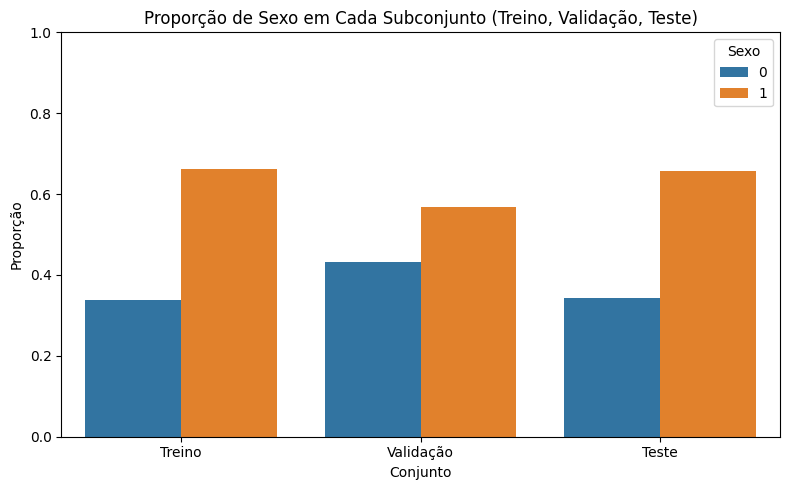

In [13]:
# Criar um DataFrame auxiliar com os conjuntos e seus respectivos sexos
def create_summary(df, name, coluna):
    return df[coluna].value_counts(normalize=True).rename_axis(coluna).reset_index(name='Proportion').assign(Subset=name)

summary_train = create_summary(X_train, 'Treino', 'Sex')
summary_val = create_summary(X_val, 'Validação', 'Sex')
summary_test = create_summary(X_test, 'Teste', 'Sex')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Sex')
plt.title('Proporção de Sexo em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

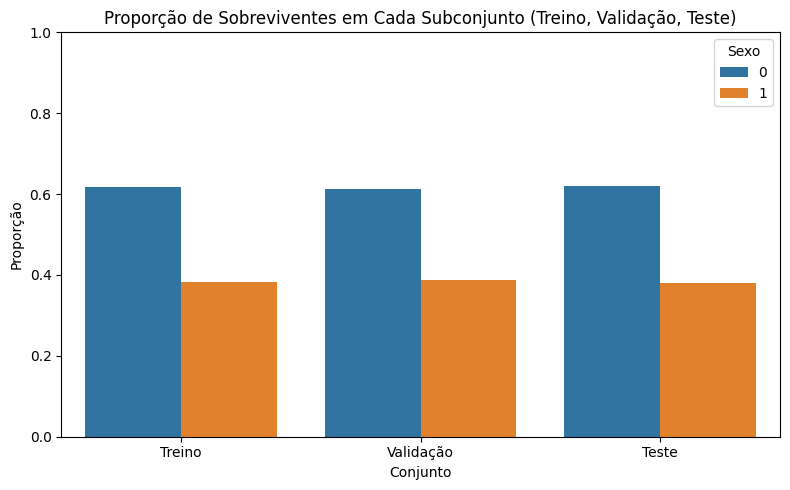

In [14]:
# Transformar as Series y_* em DataFrames com coluna nomeada
y_train_df = y_train.to_frame(name='Survived')
y_val_df = y_val.to_frame(name='Survived')
y_test_df = y_test.to_frame(name='Survived')

# Agora sim, aplicar a função corretamente
summary_train = create_summary(y_train_df, 'Treino', 'Survived')
summary_val = create_summary(y_val_df, 'Validação', 'Survived')
summary_test = create_summary(y_test_df, 'Teste', 'Survived')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Survived')
plt.title('Proporção de Sobreviventes em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

# 4. Normalização

In [15]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 5. Treinamento

In [16]:
##Modelo MLP
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/filipe-pinheiro/anaconda3/envs/main/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1752275394.315436    8815 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752275394.320564    8815 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4849 - loss: 1.2362 - val_accuracy: 0.6866 - val_loss: 1.1147
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6778 - loss: 1.0878 - val_accuracy: 0.7015 - val_loss: 1.0107
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.9932 - val_accuracy: 0.7388 - val_loss: 0.9286
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6963 - loss: 0.9326 - val_accuracy: 0.7687 - val_loss: 0.8600
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7670 - loss: 0.8562 - val_accuracy: 0.7910 - val_loss: 0.7995
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7825 - loss: 0.8104 - val_accuracy: 0.8060 - val_loss: 0.7513
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7802 - loss: 0.7545 - val_accuracy: 0.7985 - val_loss: 0.7090
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7928 - loss: 0.7037 - val_accuracy: 0.8060 - 

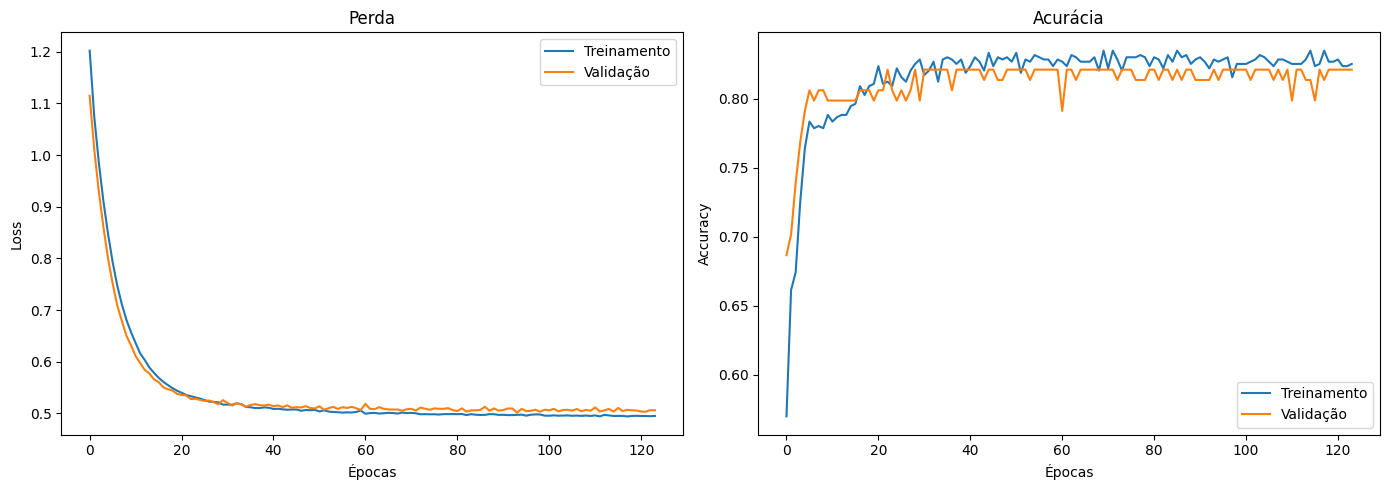

In [18]:
##Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89        83
           1       0.82      0.80      0.81        51

    accuracy                           0.86       134
   macro avg       0.85      0.85      0.85       134
weighted avg       0.86      0.86      0.86       134

Matriz de Confusão:
[[74  9]
 [10 41]]


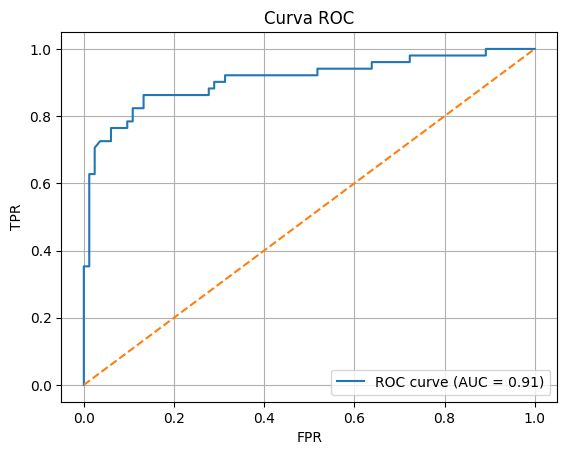

In [19]:
##Avaliação
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Análise de erro

/tmp/ipykernel_8815/3118115229.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_class = df_result.groupby('Pclass').apply(
/tmp/ipykernel_8815/3118115229.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')


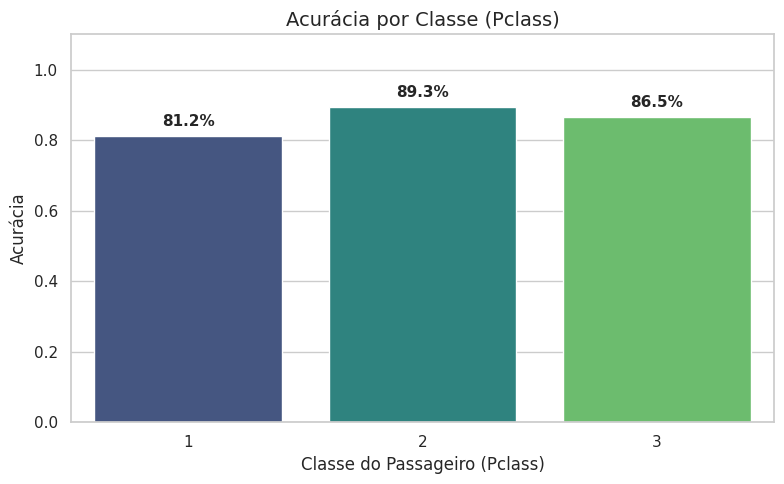

In [20]:
#@Juntar com a coluna Pclass (que vem da versão original dos dados)
df_result = pd.DataFrame({
    'Pclass': df_test_raw['Pclass'].values,
    'y_true': y_test,
    'y_pred': y_pred
})
##Calcular acurácia por Pclass
acc_by_class = df_result.groupby('Pclass').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_class.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Classe (Pclass)', fontsize=14)
plt.xlabel('Classe do Passageiro (Pclass)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)  # Deixar espaço para o texto acima das barras
plt.tight_layout()
plt.show()

/tmp/ipykernel_8815/3100036911.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby('Sex').apply(
/tmp/ipykernel_8815/3100036911.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x='Sex', y='accuracy', palette='magma')


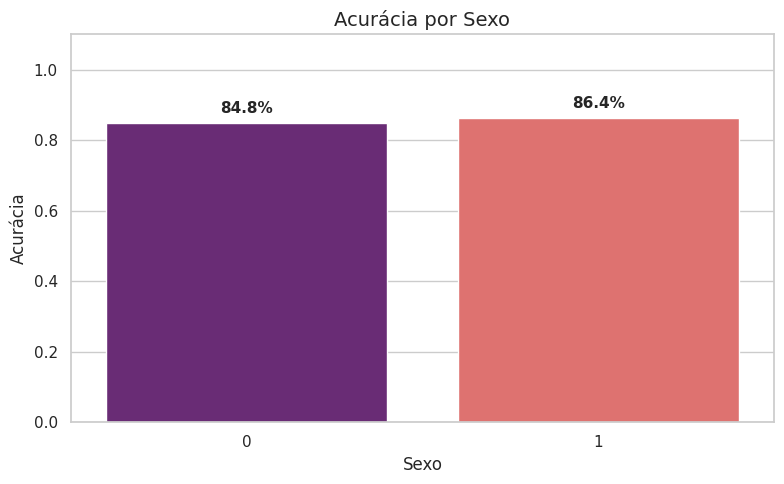

In [21]:
df_result = pd.DataFrame({
    'Sex': df_test_raw['Sex'].values,
    'y_true': y_test,
    'y_pred': y_pred
})

##Calcular acurácia por sexo
acc_by_sex = df_result.groupby('Sex').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_sex, x='Sex', y='accuracy', palette='magma')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_sex.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Sexo', fontsize=14)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


In [22]:
df_raw_train['Pclass'].value_counts()

Pclass
3    343
1    151
2    129
Name: count, dtype: int64

In [23]:
pd.crosstab(df_raw_train['Pclass'], y_train, normalize='index')


Survived,0,1
Pclass,,
1,0.370861,0.629139
2,0.527132,0.472868
3,0.758017,0.241983


# Avaliação em dados de teste fictícios

In [24]:
## Carregando os dados
df_test = pd.read_csv("data/test_fake.csv")

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Cabin_Pref_B', 'Cabin_Pref_C',
       'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n', 'Prefix_Ticket_PC'],
      dtype='object')

In [25]:
df_test.drop(columns=['PassengerId'], inplace=True)

In [26]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Smith, Mrs. Anna",female,30,1,0,PC 17599,120.00,B28,C,1
1,3,"Doe, Miss. Mary",female,25,0,0,A/5 21171,7.25,NaN,S,1
2,1,"Brown, Master. Henry",male,6,2,2,113781,150.00,C83,C,1
3,3,"Lee, Miss. Sophie",female,8,1,3,W./C. 6608,21.00,NaN,S,1
4,1,"Johnson, Mr. Robert",male,40,0,0,PC 17756,108.90,C85,S,0
5,3,"Williams, Mr. John",male,35,0,0,373450,8.05,NaN,S,0
6,1,"Taylor, Mrs. Grace",female,68,0,1,PC 17483,120.00,E31,C,1
7,3,"Clark, Mrs. Ellen",female,70,0,0,330877,7.75,NaN,Q,0
8,1,"Anderson, Mr. George",male,72,0,1,113798,80.00,D33,S,0
9,3,"Martins, Mr. Pedro",male,74,0,0,345763,6.95,NaN,S,0


In [27]:
# Cabin_Multiple: se houver mais de uma cabine listada
df_test['Cabin_Multiple'] = df_test['Cabin'].apply(lambda x: 1 if pd.notna(x) and ' ' in str(x) else 0)

# Título (prefixo do nome)
df_test['Title'] = df_test['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)

# One-hot titles
df_test['Name_Master'] = (df_test['Title'] == 'Master').astype(int)
df_test['Name_Miss'] = (df_test['Title'] == 'Miss').astype(int)
df_test['Name_Mr'] = (df_test['Title'] == 'Mr').astype(int)
df_test['Name_Mrs'] = (df_test['Title'] == 'Mrs').astype(int)

# One-hot encoding de Embarked
embarked_dummies = pd.get_dummies(df_test['Embarked'], prefix='Embarked')
for col in ['Embarked_C', 'Embarked_S', 'Embarked_Q']:
    df_test[col] = embarked_dummies.get(col, pd.Series(0, index=df_test.index))

# Cabin prefix (primeira letra da cabine)
df_test['Cabin_Pref'] = df_test['Cabin'].astype(str).str[0]
cabin_dummies = pd.get_dummies(df_test['Cabin_Pref'], prefix='Cabin_Pref')
for col in ['B', 'C', 'D', 'E', 'n']:
    df_test[f'Cabin_Pref_{col}'] = cabin_dummies.get(f'Cabin_Pref_{col}', pd.Series(0, index=df_test.index))

# Prefix_Ticket_PC
df_test['Prefix_Ticket_PC'] = df_test['Ticket'].astype(str).str.startswith('PC').astype(int)

# Converter sexo para numérico
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Converte todas as colunas booleanas para int
bool_cols = df_test.select_dtypes(include='bool').columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

# Define colunas finais de entrada (mantém Survived separada)
final_features = [
    'Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
    'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs',
    'Embarked_C', 'Embarked_S', 'Embarked_Q',
    'Cabin_Pref_B', 'Cabin_Pref_C', 'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n',
    'Prefix_Ticket_PC'
]

# Garante que apenas essas colunas + Survived permaneçam
cols_to_keep = final_features + ['Survived']
df_test = df_test[cols_to_keep].copy()


In [28]:
df_test

,Pclass,Age,Parch,SibSp,Fare,Cabin_Multiple,Sex,Name_Master,Name_Miss,Name_Mr,...,Embarked_C,Embarked_S,Embarked_Q,Cabin_Pref_B,Cabin_Pref_C,Cabin_Pref_D,Cabin_Pref_E,Cabin_Pref_n,Prefix_Ticket_PC,Survived
0,1,30,0,1,120.00,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1,3,25,0,0,7.25,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,1
2,1,6,2,2,150.00,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
3,3,8,3,1,21.00,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,1
4,1,40,0,0,108.90,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
5,3,35,0,0,8.05,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
6,1,68,1,0,120.00,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
7,3,70,0,0,7.75,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
8,1,72,1,0,80.00,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
9,3,74,0,0,6.95,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.20      0.33         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10

Matriz de Confusão:
[[5 0]
 [4 1]]


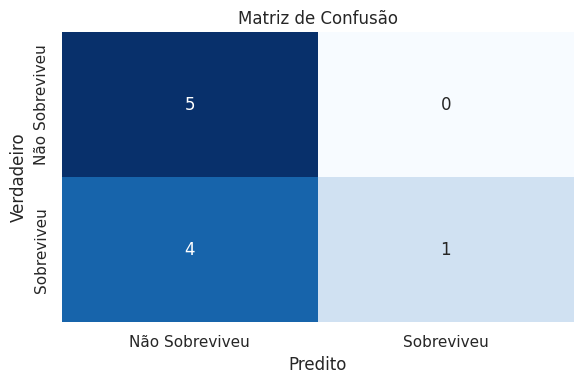

In [29]:
X_test = df_test.drop(columns=['Survived'])
y_test = df_test['Survived']

# Previsão dos dados de teste
y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Relatório
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Plotando a matriz de confusão como imagem .png
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig('matriz_confusao.png')  # Salva como imagem .png
plt.show()

# Avaliação do Conjunto de Teste sem GroundTruth

In [30]:
# Carregar o arquivo
df_kaggle_test = pd.read_csv("data/test.csv")

# Cabin_Multiple
df_kaggle_test['Cabin_Multiple'] = df_kaggle_test['Cabin'].apply(lambda x: 1 if pd.notna(x) and ' ' in str(x) else 0)

# Extrair título
df_kaggle_test['Title'] = df_kaggle_test['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)
df_kaggle_test['Name_Master'] = (df_kaggle_test['Title'] == 'Master').astype(int)
df_kaggle_test['Name_Miss'] = (df_kaggle_test['Title'] == 'Miss').astype(int)
df_kaggle_test['Name_Mr'] = (df_kaggle_test['Title'] == 'Mr').astype(int)
df_kaggle_test['Name_Mrs'] = (df_kaggle_test['Title'] == 'Mrs').astype(int)

# One-hot Embarked
embarked_dummies = pd.get_dummies(df_kaggle_test['Embarked'], prefix='Embarked')
for col in ['Embarked_C', 'Embarked_S', 'Embarked_Q']:
    df_kaggle_test[col] = embarked_dummies.get(col, pd.Series(0, index=df_kaggle_test.index))

# Prefixo da cabine
df_kaggle_test['Cabin_Pref'] = df_kaggle_test['Cabin'].astype(str).str[0]
cabin_dummies = pd.get_dummies(df_kaggle_test['Cabin_Pref'], prefix='Cabin_Pref')
for col in ['B', 'C', 'D', 'E', 'n']:
    df_kaggle_test[f'Cabin_Pref_{col}'] = cabin_dummies.get(f'Cabin_Pref_{col}', pd.Series(0, index=df_kaggle_test.index))

# Prefix_Ticket_PC
df_kaggle_test['Prefix_Ticket_PC'] = df_kaggle_test['Ticket'].astype(str).str.startswith('PC').astype(int)

# Converter 'Sex' para numérico
df_kaggle_test['Sex'] = df_kaggle_test['Sex'].map({'male': 0, 'female': 1})

# Corrigir valores booleanos
bool_cols = df_kaggle_test.select_dtypes(include='bool').columns
df_kaggle_test[bool_cols] = df_kaggle_test[bool_cols].astype(int)

# Tratar valores ausentes (Age, Fare podem estar ausentes)
df_kaggle_test['Age'] = df_kaggle_test['Age'].fillna(df_kaggle_test['Age'].median())
df_kaggle_test['Fare'] = df_kaggle_test['Fare'].fillna(df_kaggle_test['Fare'].median())

# Selecionar apenas as colunas de features
final_features = [
    'Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
    'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs',
    'Embarked_C', 'Embarked_S', 'Embarked_Q',
    'Cabin_Pref_B', 'Cabin_Pref_C', 'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n',
    'Prefix_Ticket_PC'
]

X_kaggle_test = df_kaggle_test[final_features]

In [31]:
# Previsões
y_pred_probs = model.predict(X_kaggle_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Criar CSV com os resultados
submission = pd.DataFrame({
    'PassengerId': df_kaggle_test['PassengerId'],
    'Survived': y_pred
})

# Salvar
submission.to_csv('data/submission.csv', index=False)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
